# Figure 1.f/g : Training efficiency

Goals : 

- Show that 3D models are more efficient in terms of training data needed to reach a certain accuracy, compared to 2D models.
  
(Also shows slight advantage of 3D models in terms of accuracy, and performance of self-supervised model.)

In [1]:
# TODO : add default cellpose, WNet splits, 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from tifffile import imread
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import pyclesperanto_prototype as cle
from skimage.morphology import remove_small_objects
sys.path.append("../..")

from utils import *
from plots import *

show_params()

Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [4]:
# expanded colormap has darker and lighter shades for each original color (see get_shades in utils.py)
# See intensity parameter in get_shades to adjust the intensity of the shades
# The Cellpose color needs to be there twice, we insert it between color 1 and 2
temp_cmap = COLORMAP.copy()
temp_cmap.insert(2, COLORMAP[1])
temp_cmap[1], _ = get_shades(temp_cmap[2])
EXPANDED_COLORMAP = []
for color in temp_cmap[:6]:
    colors = get_n_shades(color, 4)
    EXPANDED_COLORMAP.extend(colors)
EXPANDED_COLORMAP.extend(COLORMAP[6:])

In [5]:
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

## Data loading

In [6]:
image_folder = DATA_PATH / "RESULTS/SPLITS/Analysis/dataset_splits"
c5 = imread(image_folder / "c5.tif")
c3 = imread(image_folder / "c3.tif")
visual = imread(image_folder / "visual.tif")

gt_dict = {
    "visual": visual,
    "c3": c3,
    "c5": c5,
}

### Order data by model and split

In [7]:
def find_images(path, split):
    return list(path.glob(f"*{split}*.tif"))

#### Supervised models

In [8]:
visual_preds = {
    "Cellpose": {
        "1090": find_images(image_folder / "c1_5/cp", "1090")[0],
        "2080": find_images(image_folder / "c1_5/cp", "2080")[0],
        "6040": find_images(image_folder / "c1_5/cp", "6040")[0],
        "8020": find_images(image_folder / "c1_5/cp", "8020")[0],
    },
    "Cellpose - default": {
        "1090": find_images(image_folder / "c1_5/cp/default", "1090")[0],
        "2080": find_images(image_folder / "c1_5/cp/default", "2080")[0],
        "6040": find_images(image_folder / "c1_5/cp/default", "6040")[0],
        "8020": find_images(image_folder / "c1_5/cp/default", "8020")[0],
    },
    "StarDist": {
        "1090": find_images(image_folder / "c1_5/sd", "1090")[0],
        "2080": find_images(image_folder / "c1_5/sd", "2080")[0],
        "6040": find_images(image_folder / "c1_5/sd", "6040")[0],
        "8020": find_images(image_folder / "c1_5/sd", "8020")[0],
    },
    "SegResNet": {
        "1090": find_images(image_folder / "c1_5/segres", "1090")[0],
        "2080": find_images(image_folder / "c1_5/segres", "2080")[0],
        "6040": find_images(image_folder / "c1_5/segres", "6040")[0],
        "8020": find_images(image_folder / "c1_5/segres", "8020")[0],
    },
    "SwinUNetR": {
        "1090": find_images(image_folder / "c1_5/swin", "1090")[0],
        "2080": find_images(image_folder / "c1_5/swin", "2080")[0],
        "6040": find_images(image_folder / "c1_5/swin", "6040")[0],
        "8020": find_images(image_folder / "c1_5/swin", "8020")[0],
    },
}
c3_preds = {
    "Cellpose": {
        "1090": find_images(image_folder / "c1245_v/cp", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/cp", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/cp", "6040")[0],
        "8020" : find_images(image_folder / "c1245_v/cp", "8020")[0],
    },
    "Cellpose - default": {
        "1090": find_images(image_folder / "c1245_v/cp/default", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/cp/default", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/cp/default", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/cp/default", "8020")[0],
    },
    "StarDist": {
        "1090": find_images(image_folder / "c1245_v/sd", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/sd", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/sd", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/sd", "8020")[0],
    },
    "SegResNet": {
        "1090": find_images(image_folder / "c1245_v/segres", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "1090": find_images(image_folder / "c1245_v/swin", "1090")[0],
        "2080": find_images(image_folder / "c1245_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1245_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1245_v/swin", "8020")[0],
    },
}
c5_preds = {
    "Cellpose": {
        "1090": find_images(image_folder / "c1-4_v/cp", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/cp", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/cp", "6040")[0],
        "8020" : find_images(image_folder / "c1-4_v/cp", "8020")[0],
    },
    "Cellpose - default": {
        "1090": find_images(image_folder / "c1-4_v/cp/default", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/cp/default", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/cp/default", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/cp/default", "8020")[0],
    },
    "StarDist": {
        "1090": find_images(image_folder / "c1-4_v/sd", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/sd", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/sd", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/sd", "8020")[0],
    },
    "SegResNet": {
        "1090": find_images(image_folder / "c1-4_v/segres", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/segres", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/segres", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/segres", "8020")[0],
    },
    "SwinUNetR": {
        "1090": find_images(image_folder / "c1-4_v/swin", "1090")[0],
        "2080": find_images(image_folder / "c1-4_v/swin", "2080")[0],
        "6040": find_images(image_folder / "c1-4_v/swin", "6040")[0],
        "8020": find_images(image_folder / "c1-4_v/swin", "8020")[0],
    },
}


In [9]:
# organize as DataFrame
df = pd.DataFrame()
splits = [visual_preds, c3_preds, c5_preds]
for i, gt_name in enumerate(gt_dict):
    preds = splits[i]
    for model_name in preds:
        for split in preds[model_name]:
            gt = gt_dict[gt_name]
            df = pd.concat([df, pd.DataFrame({
                "model": model_name,
                "split": split[:2] + "/" + split[2:],
                "gt": gt_name,
                "path": [preds[model_name][split]],
            })])
df.reset_index(inplace=True, drop=True)
df

,model,split,gt,path
0,Cellpose,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
1,Cellpose,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
2,Cellpose,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
3,Cellpose,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
4,Cellpose - default,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
5,Cellpose - default,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
6,Cellpose - default,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
7,Cellpose - default,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
8,StarDist,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
9,StarDist,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...


In [10]:
df.iloc[0].path

WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SPLITS/Analysis/dataset_splits/c1_5/cp/cellpose_1090_labels.tif')

In [11]:
df.loc[len(df)] = ["WNet3D", "WNet - Artifacts", "visual", image_folder / "WNet/pretrained/visual_pred.tif"]
df.loc[len(df)] = ["WNet3D", "WNet - Artifacts", "c3", image_folder / "WNet/pretrained/c3_pred.tif"]
df.loc[len(df)] = ["WNet3D", "WNet - Artifacts", "c5", image_folder / "WNet/pretrained/c5_pred.tif"]
df

,model,split,gt,path
0,Cellpose,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
1,Cellpose,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
2,Cellpose,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
3,Cellpose,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
4,Cellpose - default,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
...,...,...,...,...
58,SwinUNetR,60/40,c5,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
59,SwinUNetR,80/20,c5,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
60,WNet3D,WNet - Artifacts,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
61,WNet3D,WNet - Artifacts,c3,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...


#### WNet3D - Splits

In [12]:
wnet_splits_preds = {
    "1090" : find_images(image_folder / "WNet/10", "pred"),
    "2080" : find_images(image_folder / "WNet/20", "pred"),
    "6040" : find_images(image_folder / "WNet/60", "pred"),
    "8020" : find_images(image_folder / "WNet/80", "pred"),
} # these are lists where each element is an image for a split (3 per split)

In [13]:
for split, image_paths in wnet_splits_preds.items():
    split = split[:2] + "/" + split[2:]
    for i, path in enumerate(image_paths):
        df.loc[len(df)] = ["WNet3D - Subsets", f"WNet - {split}", "visual", path]
df

,model,split,gt,path
0,Cellpose,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
1,Cellpose,20/80,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
2,Cellpose,60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
3,Cellpose,80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
4,Cellpose - default,10/90,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
...,...,...,...,...
70,WNet3D - Subsets,WNet - 60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
71,WNet3D - Subsets,WNet - 60/40,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
72,WNet3D - Subsets,WNet - 80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...
73,WNet3D - Subsets,WNet - 80/20,visual,C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK\...


In [14]:
model_names = ["StarDist", "Cellpose - default", "Cellpose", "SegResNet", "SwinUNetR", "WNet3D - Subsets", "WNet3D"]

```{note}
For WNet3D, we compute two sets of Dices :

- One on c3, c5 and ALL of visual, which contains some artifacts. This is "All data".
- One on c3, c5 and PART of visual, which does not contain artifacts. This is "No artifacts".

In [15]:
visual_slice = 50
visual_gt_no_artifact = gt_dict["visual"][:visual_slice,:,:]
wnet_c3_pred = imread(image_folder / "WNet/pretrained/c3_pred.tif")
wnet_c5_pred = imread(image_folder / "WNet/pretrained/c5_pred.tif")
wnet_visual_no_artifact = imread(image_folder / "WNet/pretrained/visual_pred.tif")[:visual_slice,:,:]

## Dice computation

### Pre-processing for SwinUNetR and SegResNet

In [16]:
# We use the same threshold for all splits, estimated from the training data from the supervised benchmark figure 
swin_params = {
    "thresh": 0.4,
    "spot_sigma": 0.65,
    "outline_sigma": 0.65,
}
segres_params = {
    "thresh": 0.3,
    "spot_sigma": 0.65,
    "outline_sigma": 0.65,
}
wnet_params = {
    "thresh": 0.6,
    "spot_sigma": 0.65,
    "outline_sigma": 0.65,
}

def models_instance_preprocessing(volume, params):
    volume = np.where(volume > params["thresh"], 1, 0)
    labels = cle.voronoi_otsu_labeling(volume, spot_sigma=params["spot_sigma"], outline_sigma=params["outline_sigma"])
    labels = remove_small_objects(np.array(labels), min_size=5)
    return labels

def wnet_preprocessing(volume, channel_foreground, params):
    # this should only be done on volumes with more than 3 dimensions
    if len(volume.shape) < 4:
        return volume
    volume = volume[channel_foreground]
    volume = np.where(volume > params["thresh"], 1, 0)
    labels = cle.voronoi_otsu_labeling(volume, spot_sigma=params["spot_sigma"], outline_sigma=params["outline_sigma"])
    return labels

In [17]:
# import napari
# viewer = napari.Viewer()
# # show visual gt and swin preprocessed for each split
# swin_path = df.iloc[9]
# swin_pred = imread(swin_path.path)
# viewer.add_labels(gt_dict["c3"], name="c3_gt")
# swin_pred_processed = models_instance_preprocessing(swin_pred, swin_params)
# viewer.add_labels(swin_pred_processed, name="swin_pred")
# viewer.add_image(np.swapaxes(swin_pred), name="swin_pred_raw", colormap="turbo")

In [18]:
df.set_index(
    [
    "model",
    # "split"
    ],
    inplace=True
             )

In [19]:
def model_dices_across_splits(df, verbose=False):
    dices_df = pd.DataFrame(columns=["Dice", "Model", "Split"])
    for model in model_names:
        for split in df.loc[model]["split"].unique():
            for i, row in df.loc[model][df.loc[model]["split"] == split].iterrows():
                gt = gt_dict[row["gt"]]
                pred = imread(row.path)
                if model == "SwinUNetR":
                    pred = models_instance_preprocessing(pred, swin_params)
                if model == "SegResNet":
                    pred = models_instance_preprocessing(pred, segres_params)
                if model == "WNet3D - Subsets":
                    # look into path for foreground channel : c0 indicates first channel is foreground, c1 indicates second channel is foreground
                    channel = 1 if "c1" in str(row.path) else 0
                    pred = wnet_preprocessing(pred, channel, wnet_params)
                    if row["gt"] == "visual":
                        pred = pred[:visual_slice,:,:]
                        gt = gt[:visual_slice,:,:]
                if verbose:
                    print(f"Model: {model}, Split: {split}, GT: {row['gt']}")
                    print(f"Image shape: {pred.shape}")
                    print(f"GT shape: {gt_dict[row['gt']].shape}")
                gt = np.where(gt > 0, 1, 0)
                pred = np.where(pred > 0, 1, 0)
                dice = dice_coeff(gt, pred)
                if verbose:
                    print(f"Dice: {dice}")
                    print("_"*20)
                dices_df.loc[len(dices_df)] = [dice, model, split]
    return dices_df

In [20]:
dices_df = model_dices_across_splits(df, verbose=True)

Model: StarDist, Split: 10/90, GT: visual
Image shape: (65, 127, 214)
GT shape: (65, 127, 214)
Dice: 0.45813969740382265
____________________
Model: StarDist, Split: 10/90, GT: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 1.7072712683318253e-05
____________________
Model: StarDist, Split: 10/90, GT: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 0.7047307334629646
____________________
Model: StarDist, Split: 20/80, GT: visual
Image shape: (65, 127, 214)
GT shape: (65, 127, 214)
Dice: 0.6900064226075787
____________________
Model: StarDist, Split: 20/80, GT: c3
Image shape: (149, 105, 147)
GT shape: (149, 105, 147)
Dice: 1.7072712683318253e-05
____________________
Model: StarDist, Split: 20/80, GT: c5
Image shape: (124, 86, 94)
GT shape: (124, 86, 94)
Dice: 2.441108263151471e-05
____________________
Model: StarDist, Split: 60/40, GT: visual
Image shape: (65, 127, 214)
GT shape: (65, 127, 214)
Dice: 0.6491599555678979
____________________
Model: StarDist, 

In [21]:
dices_df

,Dice,Model,Split
0,0.458140,StarDist,10/90
1,0.000017,StarDist,10/90
2,0.704731,StarDist,10/90
3,0.690006,StarDist,20/80
4,0.000017,StarDist,20/80
...,...,...,...
70,0.720902,WNet3D - Subsets,WNet - 80/20
71,0.676470,WNet3D - Subsets,WNet - 80/20
72,0.589656,WNet3D,WNet - Artifacts
73,0.811354,WNet3D,WNet - Artifacts


### WNet3D - No artifacts

In [22]:
wnet_preds_no_artifacts = { # No artifacts
    "WNet3D - No artifacts": {
        "visual": wnet_visual_no_artifact,
        "c3": wnet_c3_pred,
        "c5": wnet_c5_pred,
    }
}
gt_dict_no_artifacts = {
    "visual": visual_gt_no_artifact,
    "c3": c3,
    "c5": c5,
}
for split in wnet_preds_no_artifacts:
    for image in wnet_preds_no_artifacts[split]:
        gt = gt_dict_no_artifacts[image]
        pred = wnet_preds_no_artifacts[split][image]
        gt = np.where(gt > 0, 1, 0)
        pred = np.where(pred > 0, 1, 0)
        dice = dice_coeff(gt, pred)
        print(f"Split: {split}, Image: {image}, Dice: {dice}")
        dices_df.loc[len(dices_df)] = [dice, "WNet3D", split]

Split: WNet3D - No artifacts, Image: visual, Dice: 0.8179572126452918
Split: WNet3D - No artifacts, Image: c3, Dice: 0.8113536341409202
Split: WNet3D - No artifacts, Image: c5, Dice: 0.8087545264446371


### Detailed stats 
Shows means and stds of select splits for manuscript.

In [23]:
dice_df_8020 = dices_df[dices_df["Split"] == "80/20"]
dice_df_8020.groupby("Model", sort=False).agg({"Dice": ["mean", "std"]})

Dice          
                        mean       std
Model                                 
StarDist            0.605878  0.073826
Cellpose - default  0.437450  0.088021
Cellpose            0.760962  0.034985
SegResNet           0.746871  0.069419
SwinUNetR           0.829685  0.002778

In [24]:
dice_df_wnet = dices_df[dices_df["Model"] == "WNet3D"]
dice_df_wnet.groupby("Split").agg({"Dice": ["mean", "std"]})

Dice          
                           mean       std
Split                                    
WNet - Artifacts       0.736588  0.127254
WNet3D - No artifacts  0.812688  0.004744

In [25]:
dice_df_wnet_trained_on_subsets = dices_df[dices_df["Model"] == "WNet3D - Subsets"]
dice_df_wnet_trained_on_subsets.groupby("Split").agg({"Dice": ["mean", "std"]})

Dice          
                  mean       std
Split                           
WNet - 10/90  0.736576  0.017911
WNet - 20/80  0.737155  0.010214
WNet - 60/40  0.710796  0.031499
WNet - 80/20  0.711391  0.031270

## Plots

In [26]:
dices_df['Model_Split'] = dices_df['Model'] + ' (' + dices_df['Split'].astype(str) + ')'

Due to the way seaborn boxplots interact with categories, the axes will be generated for all models/splits, and then separate boxplots are used to have readable boxes for each model.

The data is the same everywhere, this is only to have cleaner figures.

In addition, since SwinUNetR and WNet have much smaller variance, we show a zoomed-in inset for these models.

### General plot

#### All models

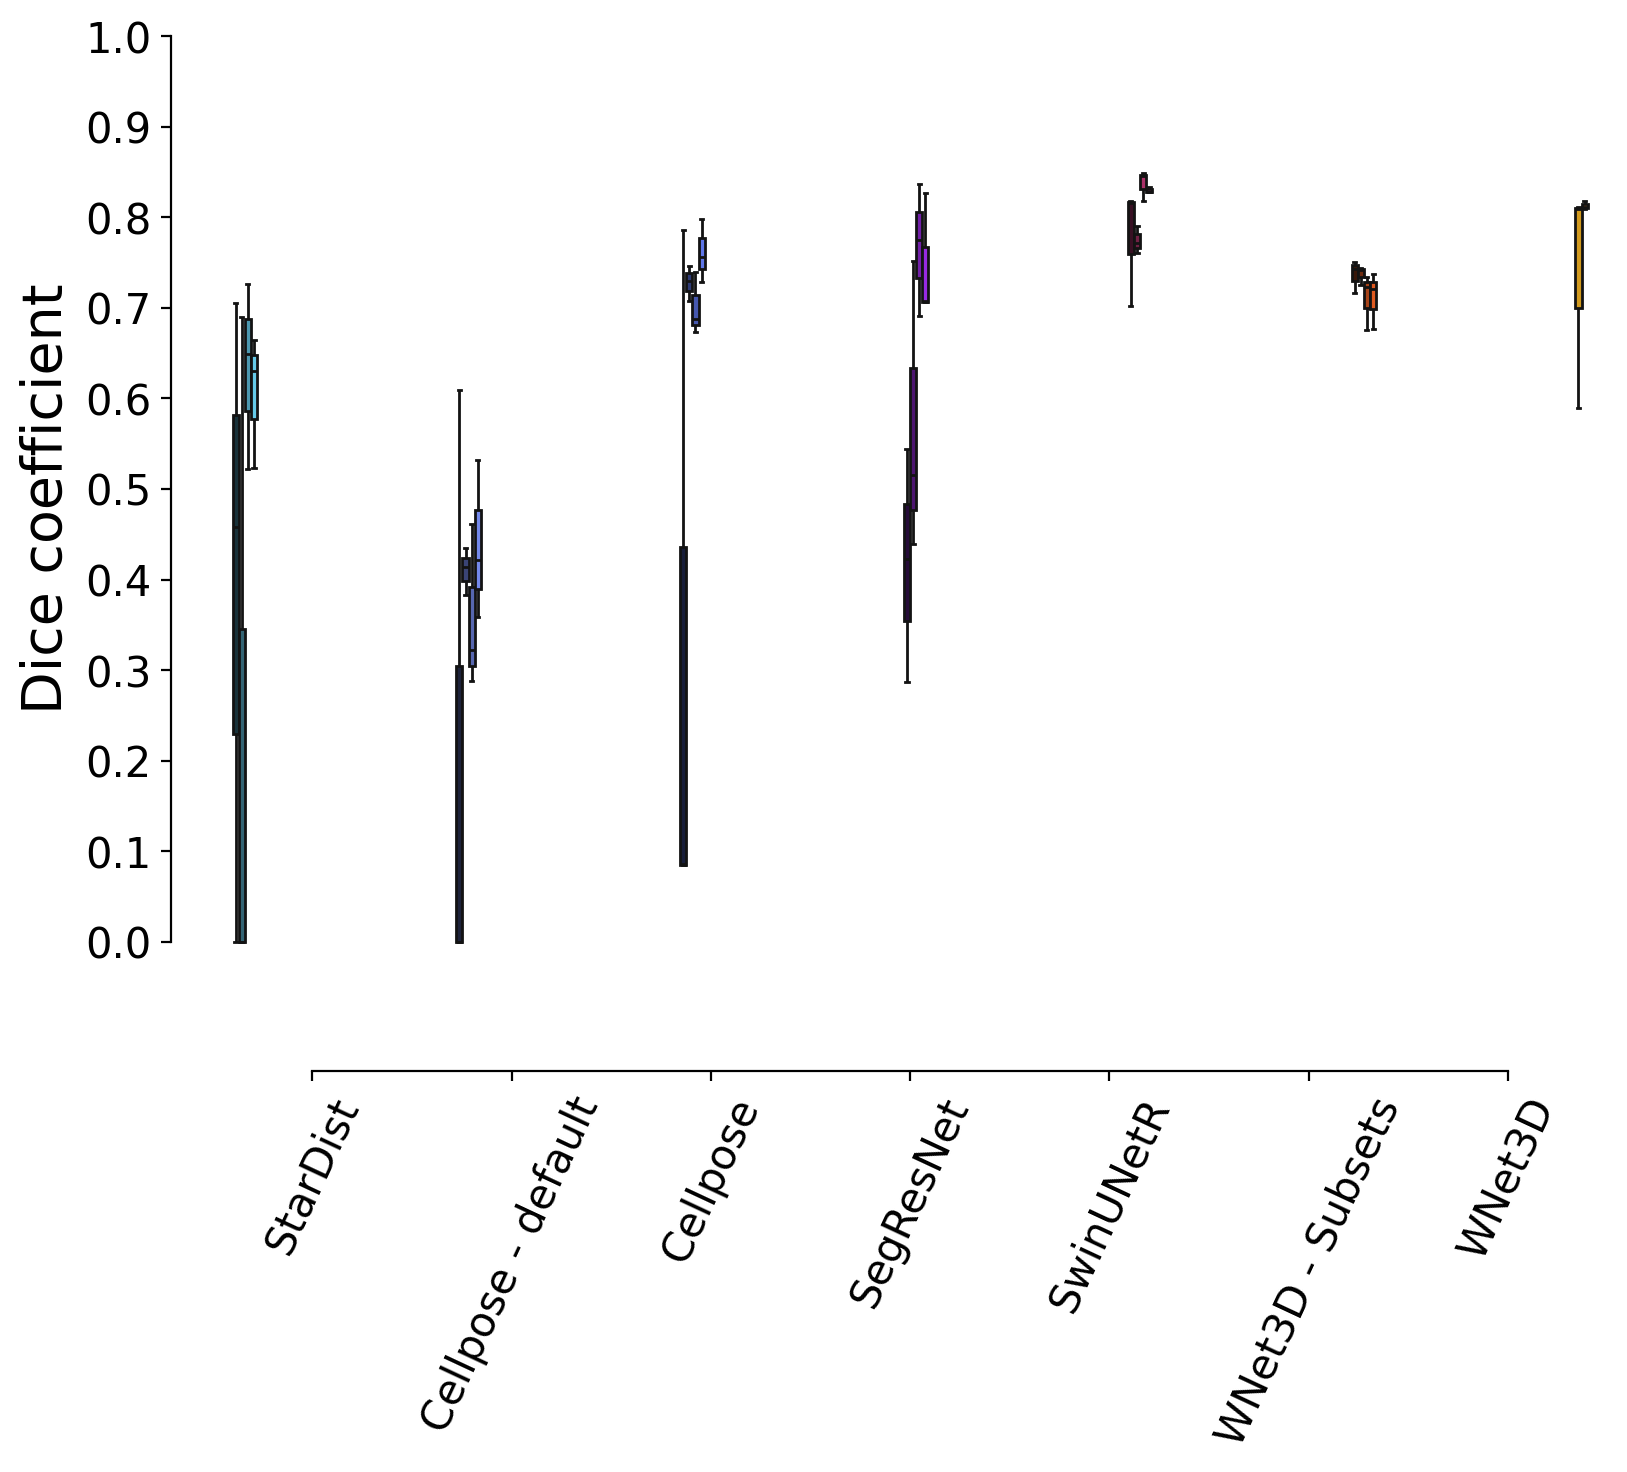

In [27]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=DPI)
sns.boxplot(
    data=dices_df,
    x="Model", 
    y="Dice", 
    hue="Model_Split", 
    ax=ax, 
    palette=EXPANDED_COLORMAP,
    # dodge=False,
    )
for i, artist in enumerate(ax.artists): # try to center the boxplot on xticks
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(artist.get_facecolor())
        if j % 6 == 4: 
            x, y = line.get_xydata()[0]
            x_center = i // 2 
            if i % 2: 
                line.set_xdata([x_center + 0.2, x_center + 0.2, x, x_center + 0.2])
            else:  
                line.set_xdata([x_center - 0.2, x_center - 0.2, x, x_center - 0.2])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 65)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency.svg", bbox_inches="tight")

### Legend

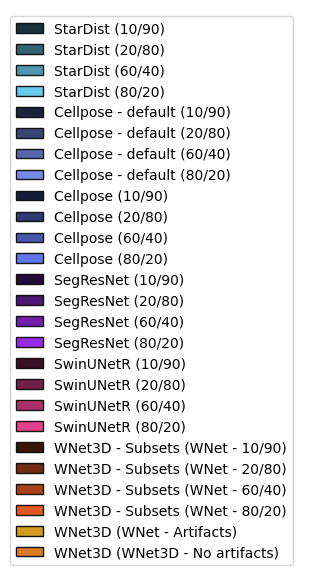

In [28]:
fig_leg = plt.figure(figsize=(3, 2))
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend.legend_handles, labels=[text.get_text() for text in legend.texts])
ax_leg.axis('off')
plt.show()
if SAVE_PLOTS_AS_PNG:
    fig_leg.savefig("Label_efficiency_legend.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig_leg.savefig("Label_efficiency_legend.svg", bbox_inches="tight")

#### Self-supervised models

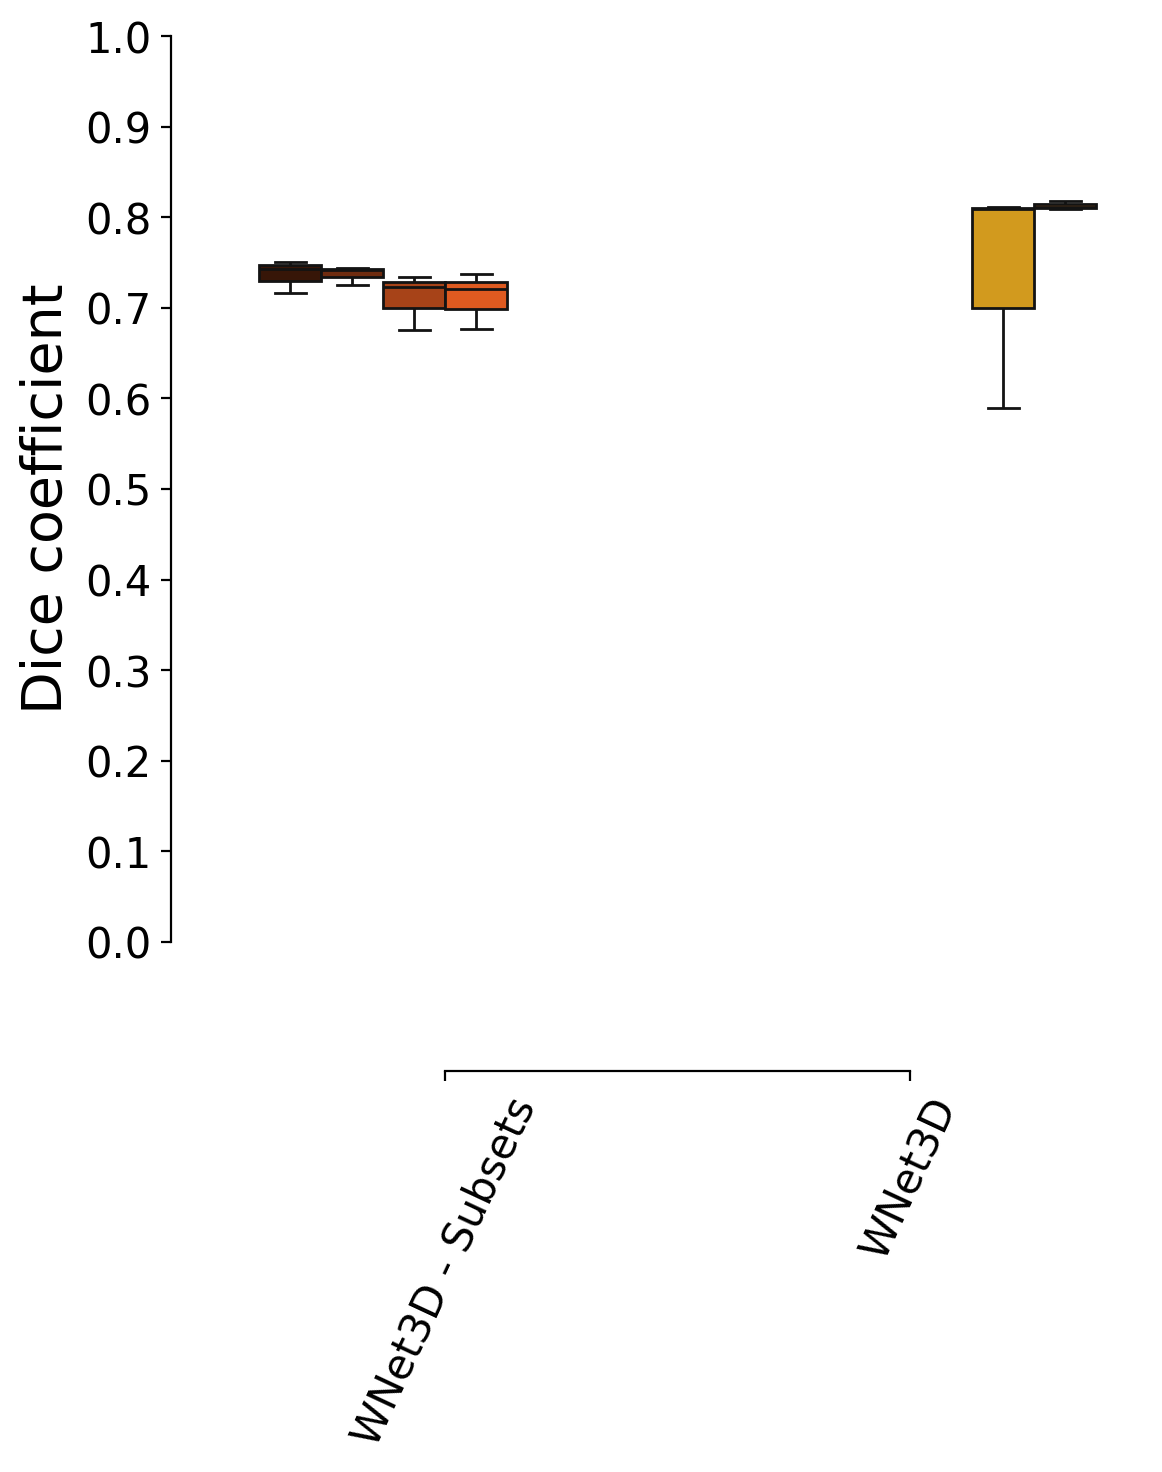

In [29]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=DPI)
wnet_models = ["WNet3D", "WNet3D - Subsets"]
dices_df_selfsupervised = dices_df[dices_df["Model"].isin(wnet_models)]
sns.boxplot(
    data=dices_df_selfsupervised,
    x="Model", 
    y="Dice", 
    hue="Model_Split", 
    ax=ax, 
    palette=EXPANDED_COLORMAP[20:]
    # dodge=False,
    )
for i, artist in enumerate(ax.artists): # try to center the boxplot on xticks
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(artist.get_facecolor())
        if j % 6 == 4: 
            x, y = line.get_xydata()[0]
            x_center = i // 2 
            if i % 2: 
                line.set_xdata([x_center + 0.2, x_center + 0.2, x, x_center + 0.2])
            else:  
                line.set_xdata([x_center - 0.2, x_center - 0.2, x, x_center - 0.2])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 65)
plt.ylim([-0.02,1])
ax.set_yticks(np.arange(0,1.1,0.1))
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
legend.get_frame().set_alpha(0)
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
plt.legend([],[], frameon=False)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_selfsup.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_selfsup.svg", bbox_inches="tight")

### Boxplots for each model

StarDist


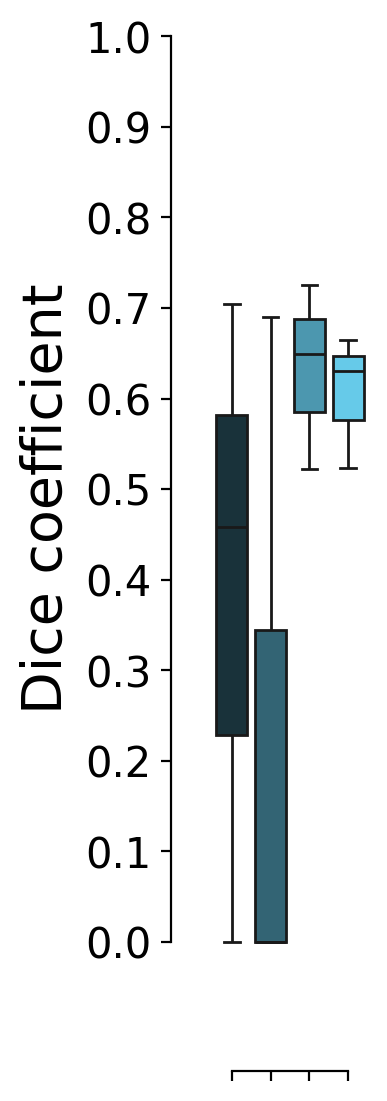

Cellpose - default


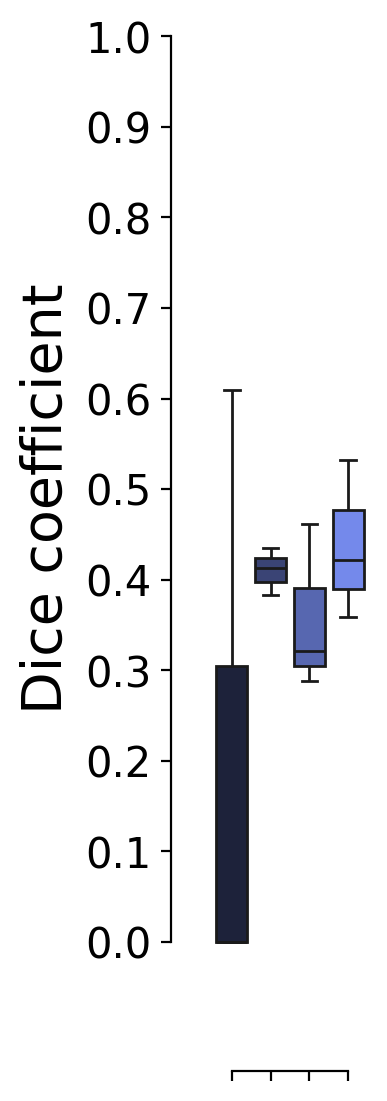

Cellpose


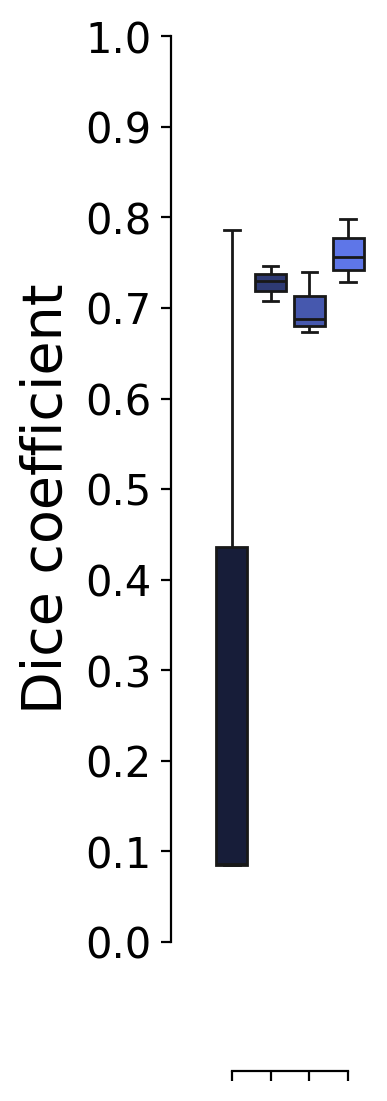

SegResNet


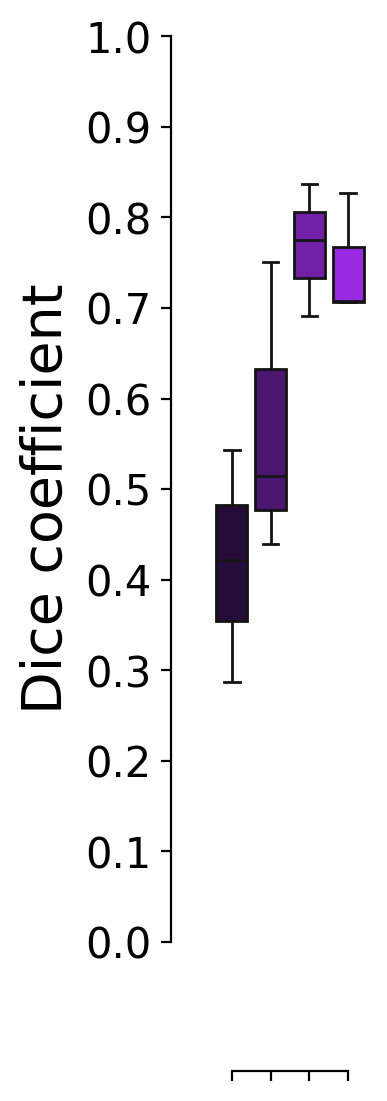

SwinUNetR


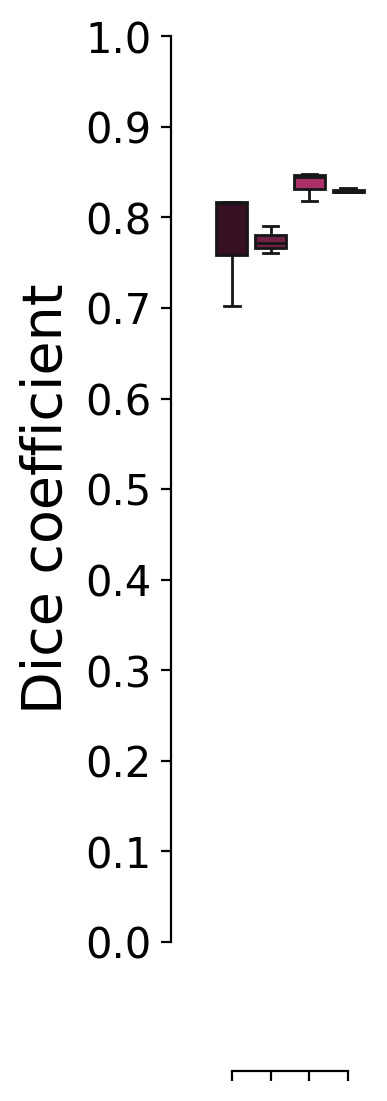

WNet3D - Subsets


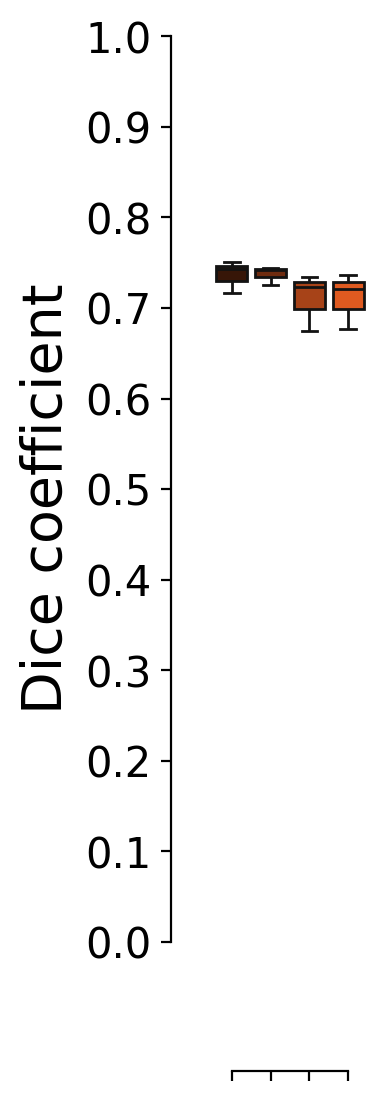

WNet3D


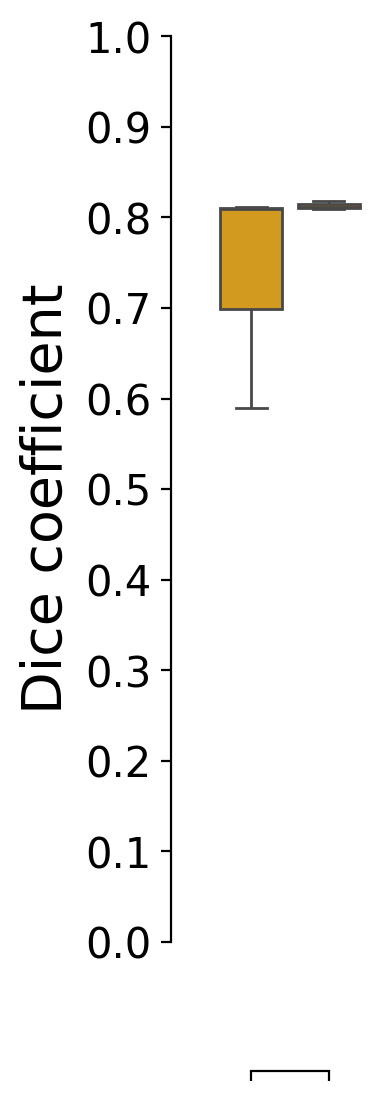

In [30]:
models_dfs = [dices_df[dices_df["Model"] == model].copy() for model in model_names]
save_path = Path("label_efficiency")
save_path.mkdir(exist_ok=True)
for i, model in enumerate(model_names):
    print(model)
    # figsize_width = 1 if model != "WNet - Ours" else 0.33 # does not accept float values
    fig, ax = plt.subplots(figsize=(1, 6), dpi=DPI)
    df = models_dfs[i]
    sns.boxplot(
        data=df,
        x="Model_Split", 
        y="Dice", 
        hue="Split", 
        ax=ax, 
        palette=EXPANDED_COLORMAP[0+4*i:4+4*i],
    )
    ax.tick_params(axis = 'x',   rotation = 45)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
    ax.set_yticks(np.arange(0,1.1,0.1))
    ax.set_ylim([-0.02,1])
    sns.despine(
        left=False,
        right=True,
        bottom=False,
        top=True,
        trim=True,
        offset={"bottom": 40, "left": 15},
        ax=ax
    )
    ax.set_xticklabels("", fontsize=LABEL_FONT_SIZE)
    ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
    ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
    ax.legend([],[], frameon=False)
    ax.patch.set_alpha(0)
    legend = ax.get_legend()
    if legend:
        legend.remove()
    # ax.set_title(model, fontsize=LABEL_FONT_SIZE)
    fig.patch.set_alpha(0)
    plt.show()
    if SAVE_PLOTS_AS_PNG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.png", dpi=DPI, bbox_inches="tight")
    if SAVE_PLOTS_AS_SVG:
        fig.savefig(f"{str(save_path)}/Label_efficiency_{model}.svg", bbox_inches="tight")

### Zoom-in for rightmost models

C:\Users\Cyril\AppData\Local\Temp\ipykernel_3168\1916514661.py:4: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.boxplot(data=zoom_dices_df, x="Model", y="Dice", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[16:], dodge=True)


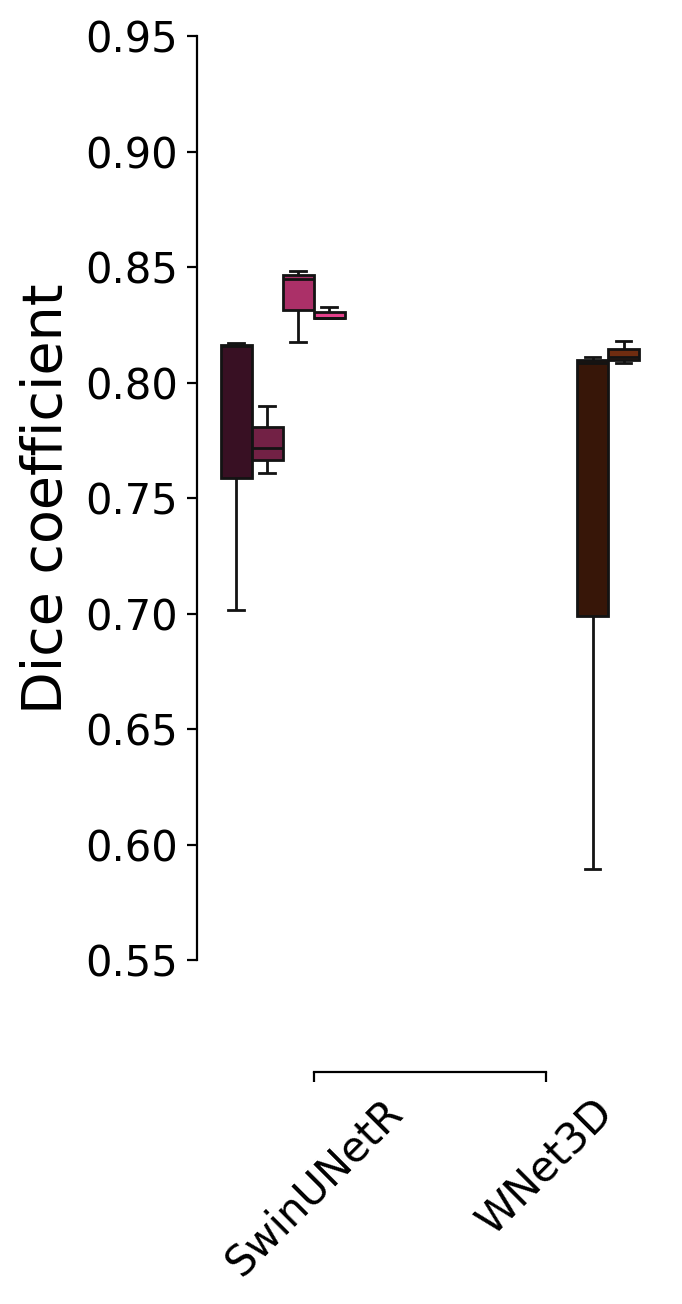

In [31]:
# same as above with Swin and WNet and y axis on the right
fig, ax = plt.subplots(figsize=(3, 6), dpi=DPI)
zoom_dices_df = dices_df[dices_df["Model"].isin(["SwinUNetR", "WNet3D"])]
sns.boxplot(data=zoom_dices_df, x="Model", y="Dice", hue="Split", ax=ax, palette=EXPANDED_COLORMAP[16:], dodge=True)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=LEGEND_FONT_SIZE)
ax.tick_params(axis = 'x',   rotation = 45,)
# ax.set_ylim([0.8,0.85])
# ax.set_yticks(np.arange(0.8,0.86,0.01))
ax.set_ylim([0.55,0.95])
ax.set_yticks(np.arange(0.55,0.96,0.05))
ax.set_xlabel("", fontsize=LABEL_FONT_SIZE)
ax.set_ylabel("Dice coefficient", fontsize=LABEL_FONT_SIZE)
ax.legend_.remove()
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "right": 15},
)
# legend = ax.legend(fontsize=LEGEND_FONT_SIZE, bbox_to_anchor=BBOX_TO_ANCHOR, loc=LOC)
# legend.get_frame().set_alpha(0)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_SWIN_WNET_zoom.svg", bbox_inches="tight")

## Statistical tests

Here we run a Kruskal-Wallis test to assess if all models differ from each other, when performance is averaged across splits. 

### Performance across models


In [32]:
dices_df

,Dice,Model,Split,Model_Split
0,0.458140,StarDist,10/90,StarDist (10/90)
1,0.000017,StarDist,10/90,StarDist (10/90)
2,0.704731,StarDist,10/90,StarDist (10/90)
3,0.690006,StarDist,20/80,StarDist (20/80)
4,0.000017,StarDist,20/80,StarDist (20/80)
...,...,...,...,...
73,0.811354,WNet3D,WNet - Artifacts,WNet3D (WNet - Artifacts)
74,0.808755,WNet3D,WNet - Artifacts,WNet3D (WNet - Artifacts)
75,0.817957,WNet3D,WNet3D - No artifacts,WNet3D (WNet3D - No artifacts)
76,0.811354,WNet3D,WNet3D - No artifacts,WNet3D (WNet3D - No artifacts)


C:\Users\Cyril\AppData\Local\Temp\ipykernel_3168\3279993741.py:6: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.boxplot(data=dices_df, hue="Model", y="Dice", palette=temp_cmap, ax=ax)


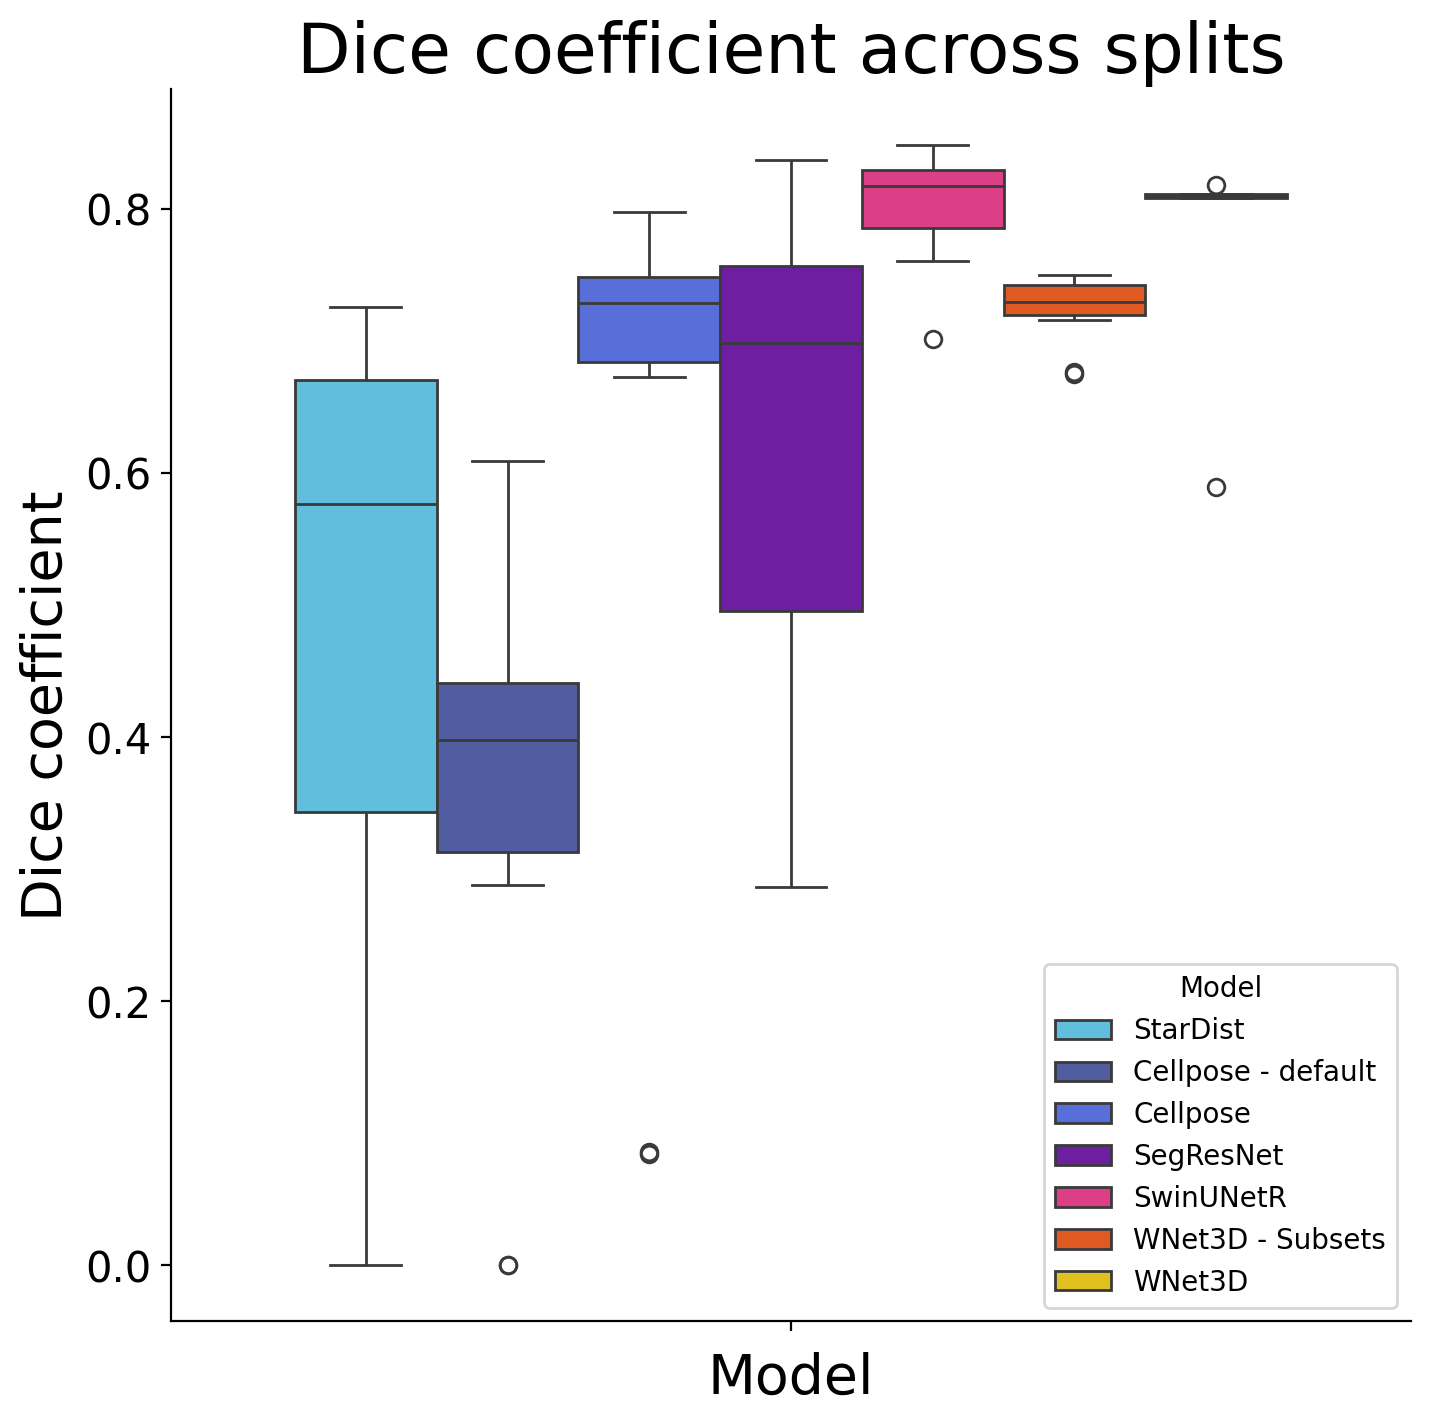

In [37]:
from plots import _format_plot

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
test_df = dices_df[dices_df["Split"] != "WNet - Artifacts"]
test_df = test_df.groupby("Model", sort=False).Dice.apply(list).reset_index()
sns.boxplot(data=dices_df, hue="Model", y="Dice", palette=temp_cmap, ax=ax)
_format_plot(ax, xlabel="Model", ylabel="Dice coefficient", title="Dice coefficient across splits")
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
plt.show()

if SAVE_PLOTS_AS_PNG:
    fig.savefig("Label_efficiency_all_models_averaged.png", dpi=DPI)
if SAVE_PLOTS_AS_SVG:
    fig.savefig("Label_efficiency_all_models_averaged.svg", bbox_inches="tight")

In [34]:
print(kruskal(*test_df.Dice.tolist()))

KruskalResult(statistic=45.11294544419942, pvalue=4.444478715319186e-08)


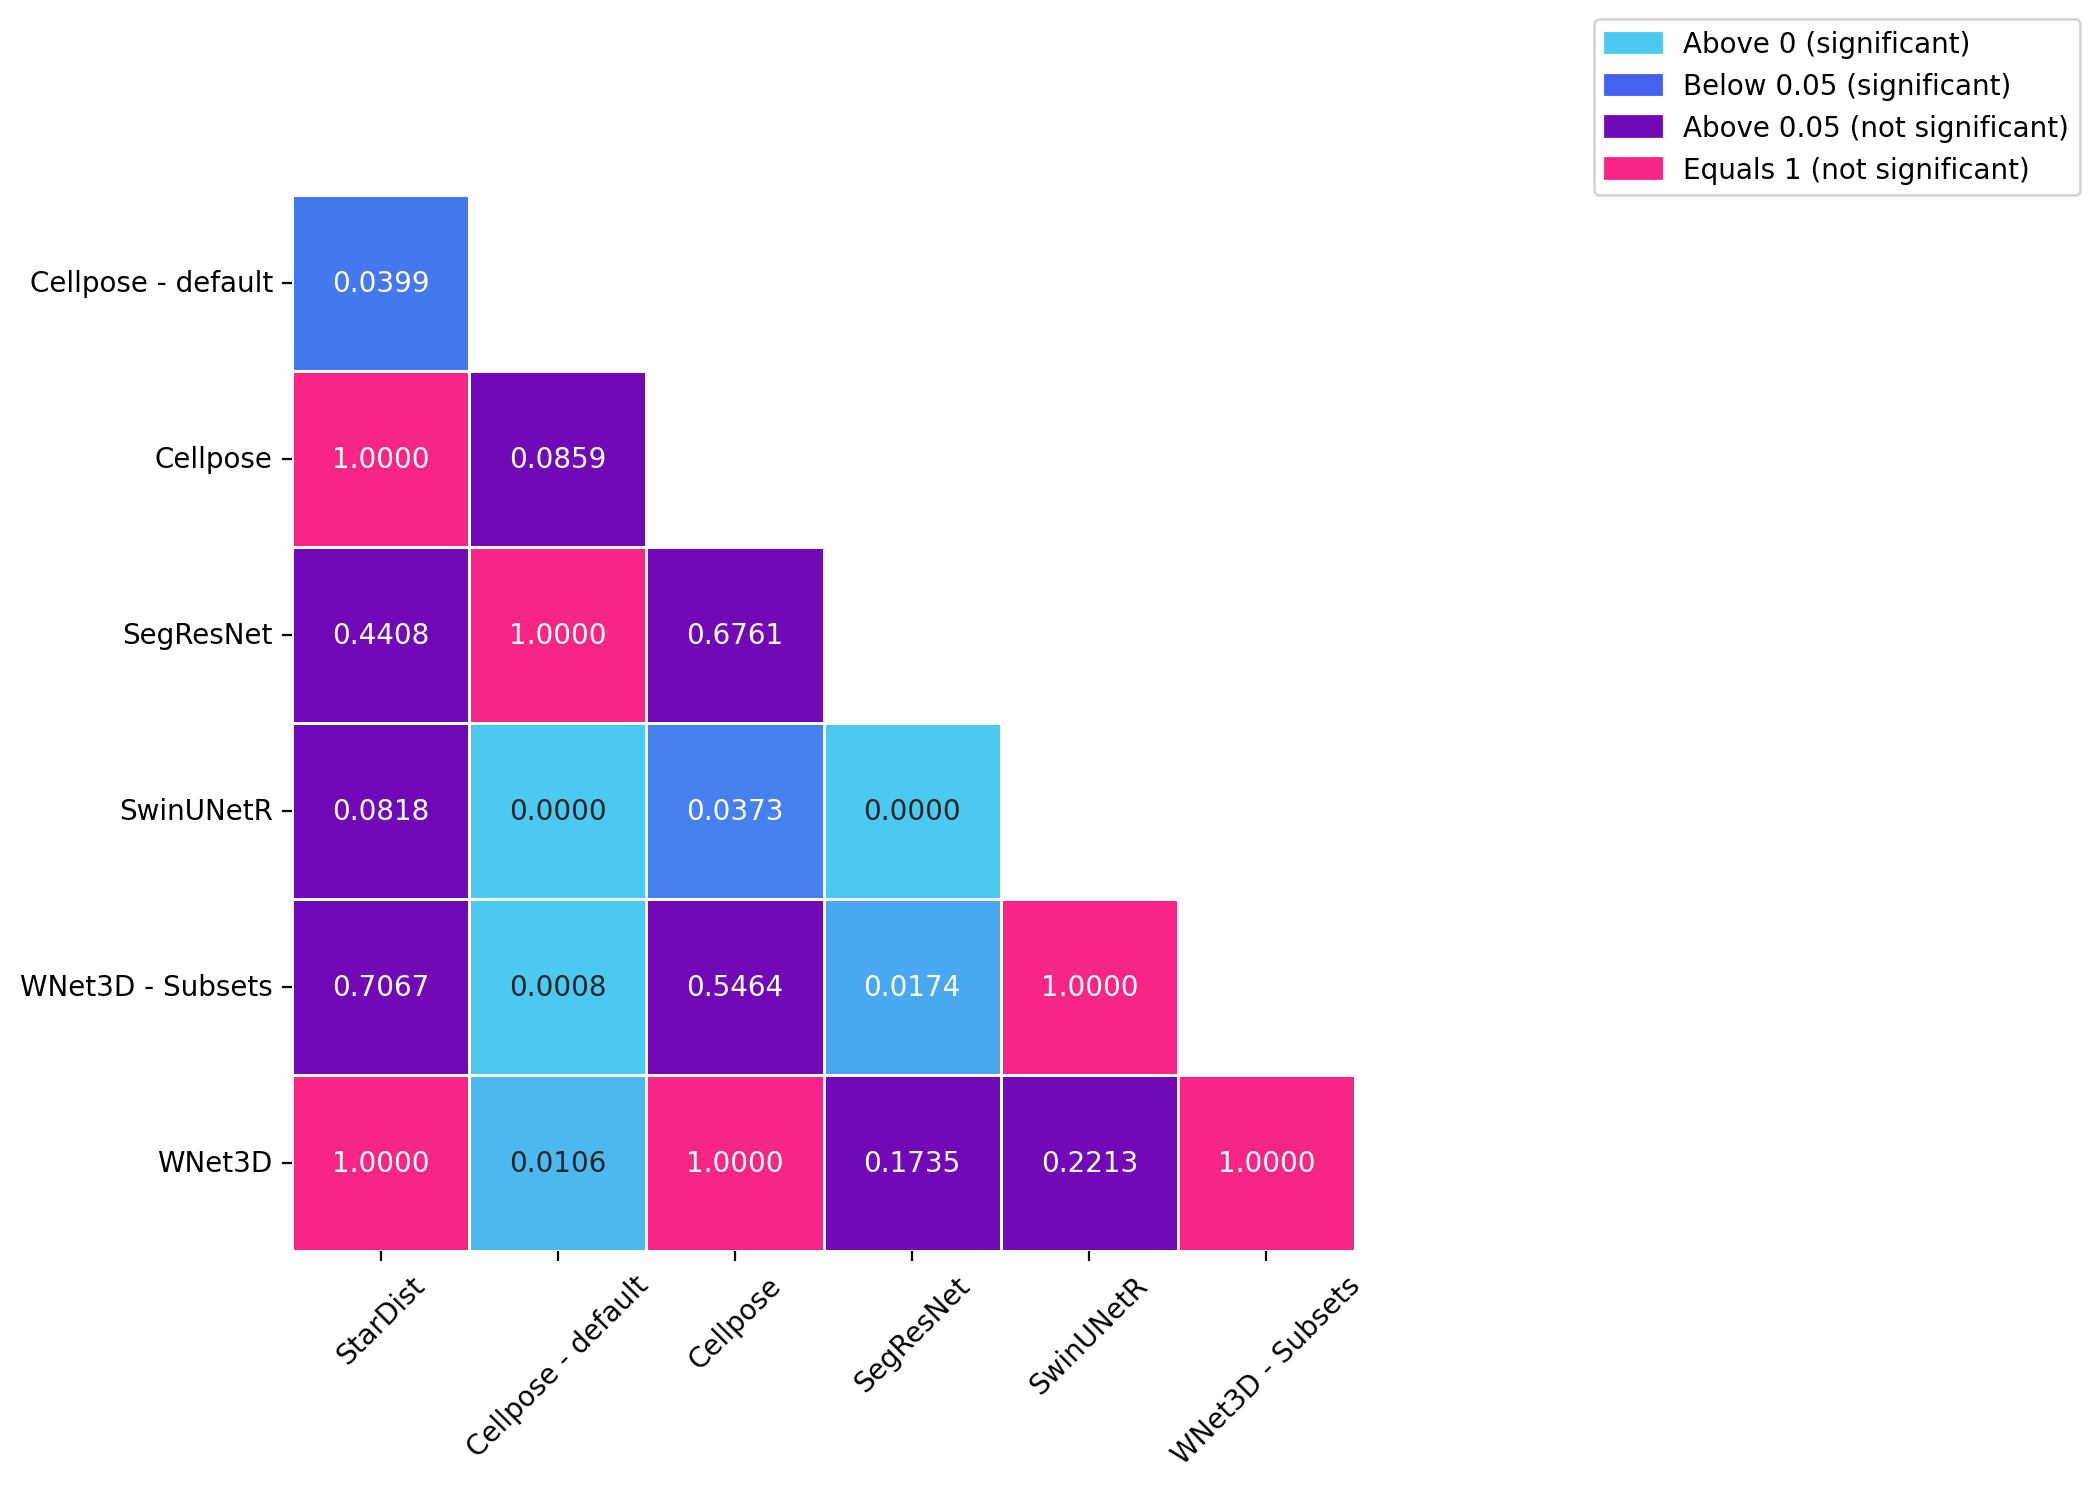

In [68]:
from scikit_posthocs import posthoc_dunn
import matplotlib.colors as colors
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
results = posthoc_dunn(dices_df, val_col="Dice", group_col="Model", p_adjust="holm")

low_color = COLORMAP[0]
mid_color = COLORMAP[1]
high_color = COLORMAP[2]
equals_1_color = COLORMAP[3]

levels = [0, 0.05, 0.06, 0.99, 1]
colors_list = [low_color, mid_color, high_color, high_color, equals_1_color]
cmap = colors.LinearSegmentedColormap.from_list("", list(zip(levels, colors_list)))
norm = colors.Normalize(vmin=0, vmax=1)

# only show lower triangle using mask
mask = np.triu(np.ones_like(results, dtype=bool))
sns.heatmap(results, annot=True, cmap=cmap, norm=norm, cbar=False, fmt=".4f", linewidths=0.5, ax=ax, mask=mask)

plt.xticks(ticks=np.arange(0.5, len(model_names)-1, 1), labels=model_names[:-1], rotation=45)
plt.yticks(ticks=np.arange(1.5, len(model_names), 1), labels=model_names[1:], rotation=0)

patches = [mpatches.Patch(color=low_color, label='Above 0 (significant)'),
           mpatches.Patch(color=mid_color, label='Below 0.05 (significant)'),
           mpatches.Patch(color=high_color, label='Above 0.05 (not significant)'),
           mpatches.Patch(color=equals_1_color, label='Equals 1 (not significant)')]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# transparent background
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    plt.savefig("Label_efficiency_posthoc_dunn.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("Label_efficiency_posthoc_dunn.svg", bbox_inches="tight")

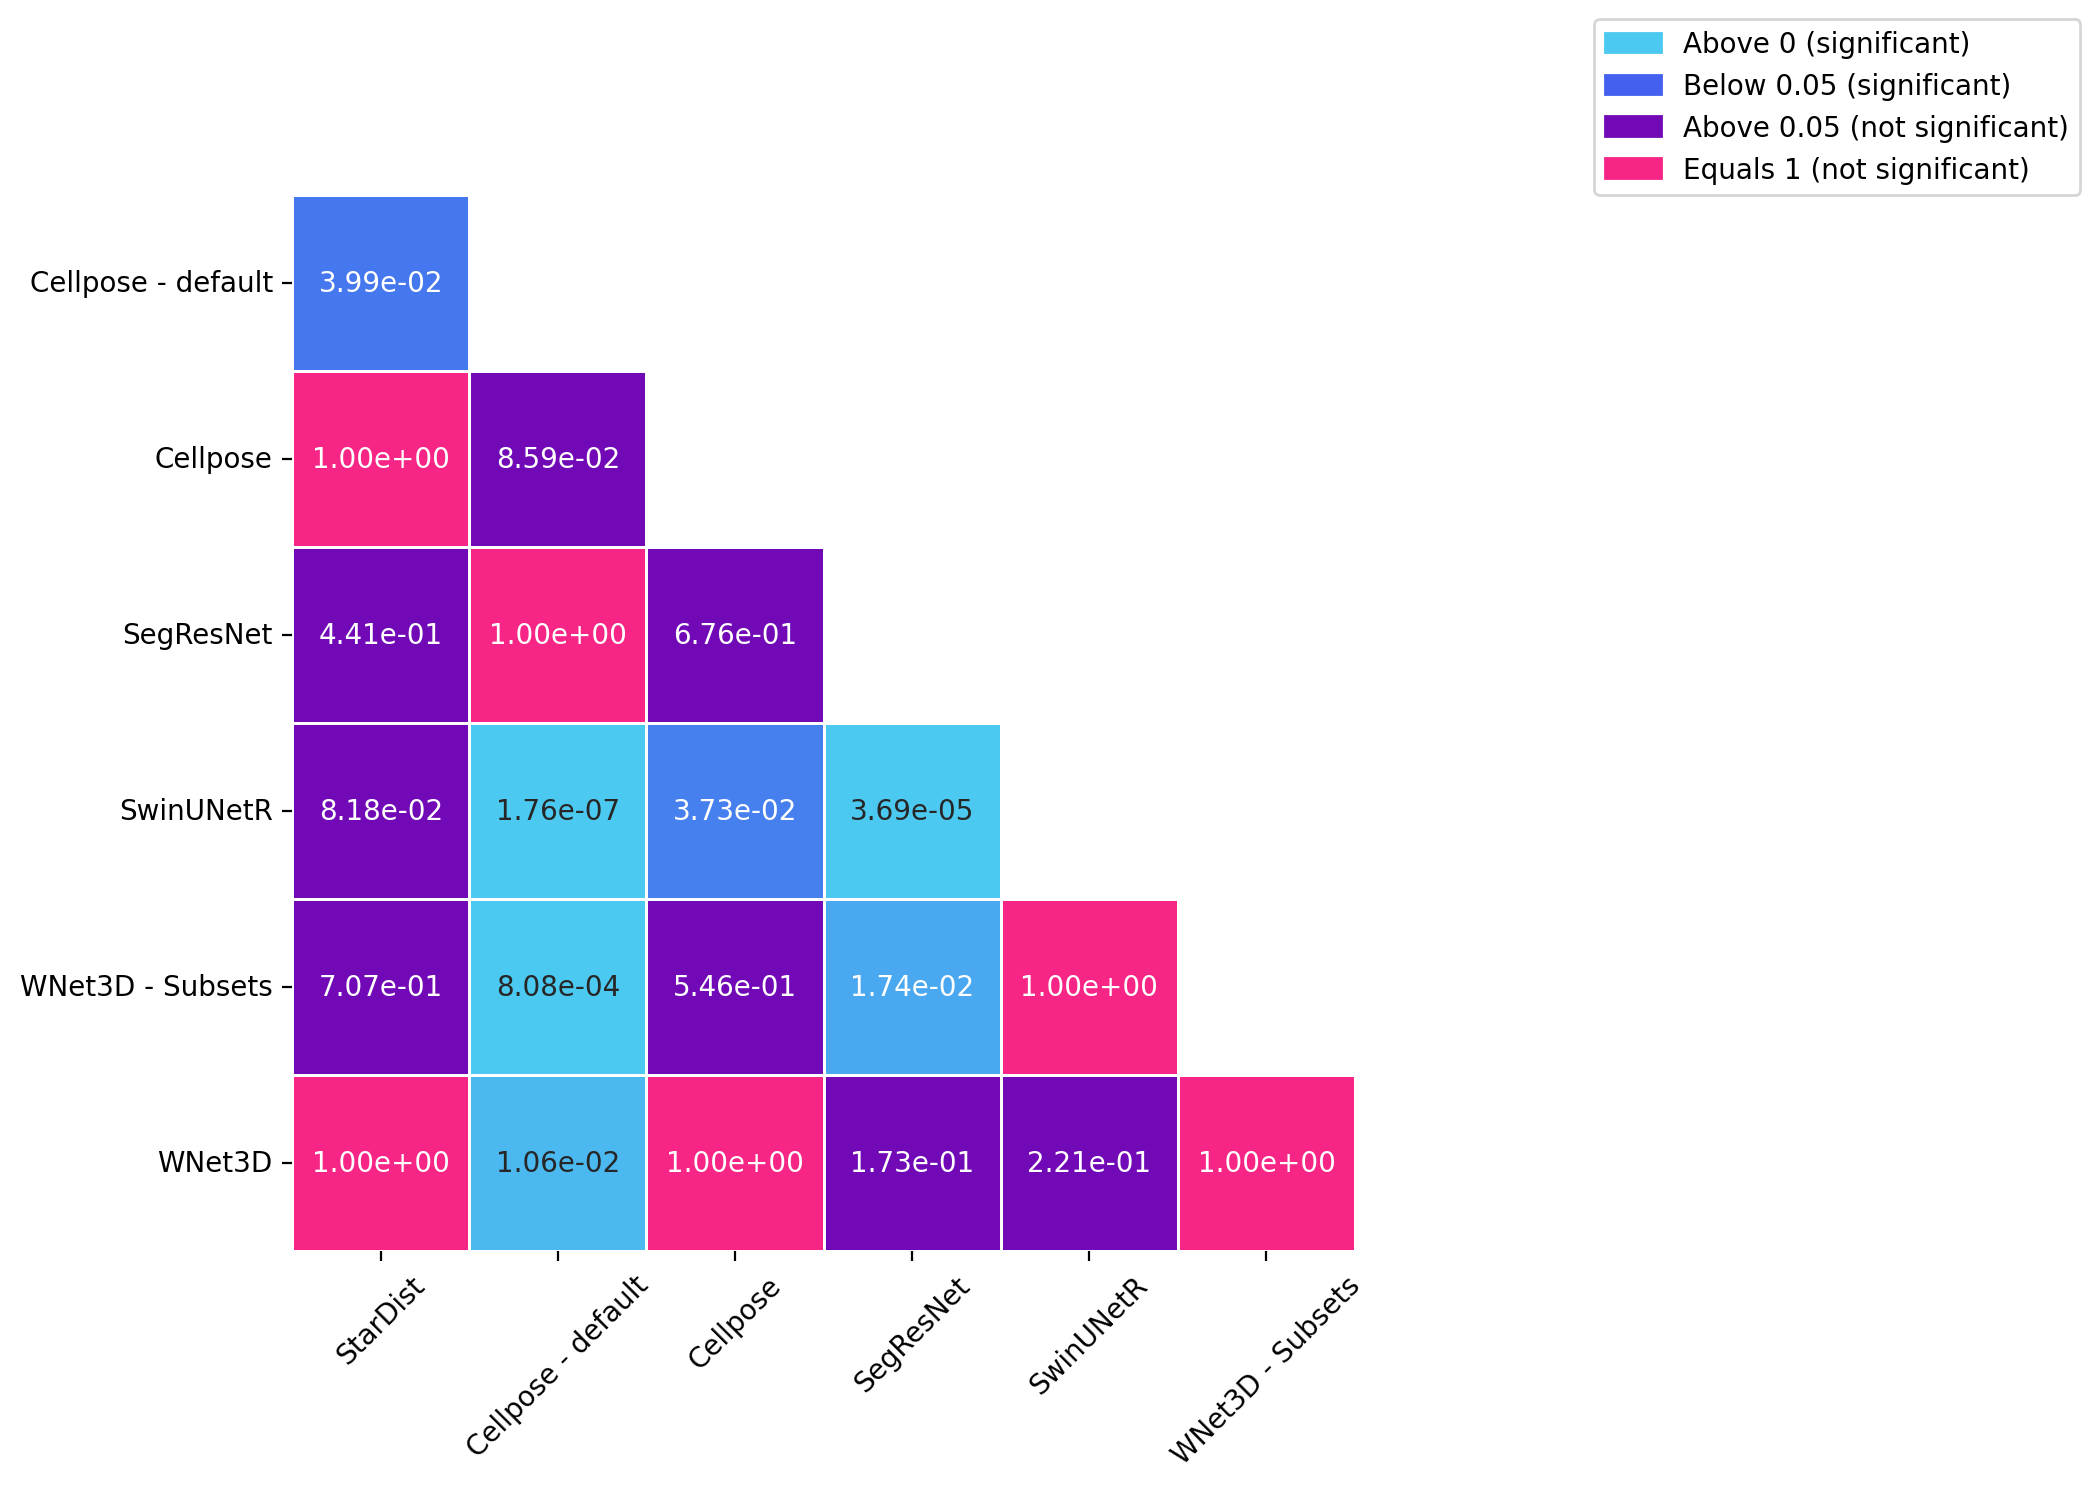

In [71]:
from scikit_posthocs import posthoc_dunn
import matplotlib.colors as colors
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
results = posthoc_dunn(dices_df, val_col="Dice", group_col="Model", p_adjust="holm")

low_color = COLORMAP[0]
mid_color = COLORMAP[1]
high_color = COLORMAP[2]
equals_1_color = COLORMAP[3]

levels = [0, 0.05, 0.06, 0.99, 1]
colors_list = [low_color, mid_color, high_color, high_color, equals_1_color]
cmap = colors.LinearSegmentedColormap.from_list("", list(zip(levels, colors_list)))
norm = colors.Normalize(vmin=0, vmax=1)

# only show lower triangle using mask
mask = np.triu(np.ones_like(results, dtype=bool))

sns.heatmap(results, annot=True, cmap=cmap, norm=norm, cbar=False, fmt=".2e", linewidths=0.5, ax=ax, mask=mask)

plt.xticks(ticks=np.arange(0.5, len(model_names)-1, 1), labels=model_names[:-1], rotation=45)
plt.yticks(ticks=np.arange(1.5, len(model_names), 1), labels=model_names[1:], rotation=0)

patches = [mpatches.Patch(color=low_color, label='Above 0 (significant)'),
           mpatches.Patch(color=mid_color, label='Below 0.05 (significant)'),
           mpatches.Patch(color=high_color, label='Above 0.05 (not significant)'),
           mpatches.Patch(color=equals_1_color, label='Equals 1 (not significant)')]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# transparent background
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    plt.savefig("Label_efficiency_posthoc_dunn_scinot.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("Label_efficiency_posthoc_dunn_scinot.svg", bbox_inches="tight")

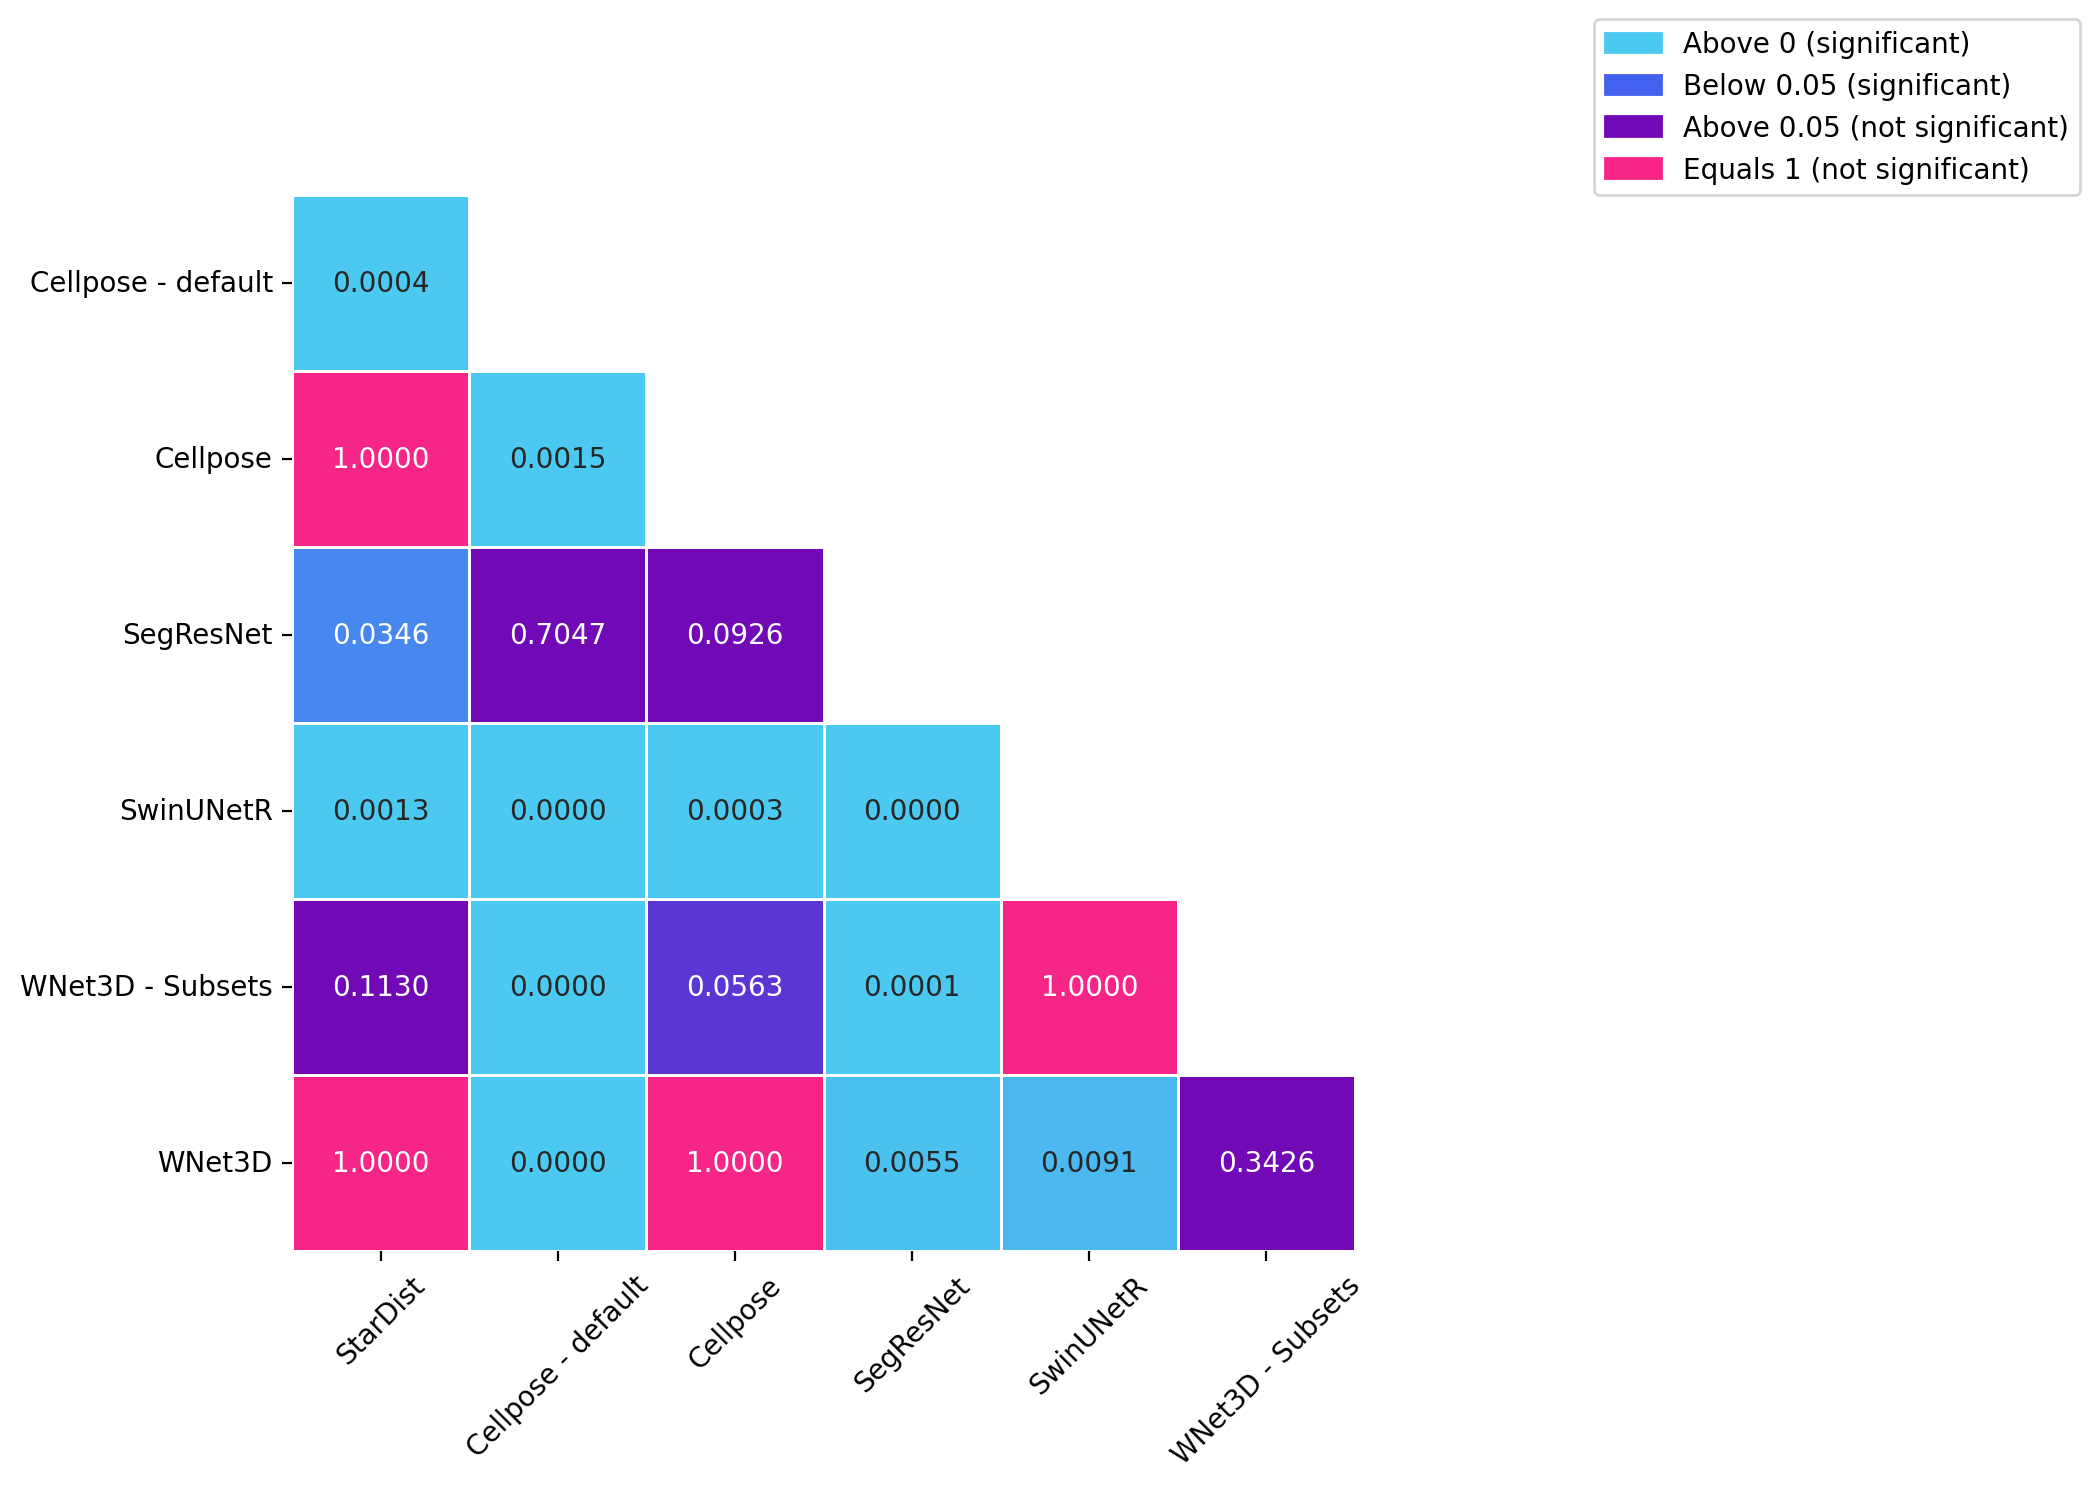

In [72]:
from scikit_posthocs import posthoc_conover
import matplotlib.colors as colors
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8), dpi=DPI)
results = posthoc_conover(dices_df, val_col="Dice", group_col="Model", p_adjust="holm")

low_color = COLORMAP[0]
mid_color = COLORMAP[1]
high_color = COLORMAP[2]
equals_1_color = COLORMAP[3]

levels = [0, 0.05, 0.06, 0.99, 1]
colors_list = [low_color, mid_color, high_color, high_color, equals_1_color]
cmap = colors.LinearSegmentedColormap.from_list("", list(zip(levels, colors_list)))
norm = colors.Normalize(vmin=0, vmax=1)

# only show lower triangle using mask
mask = np.triu(np.ones_like(results, dtype=bool))
sns.heatmap(results, annot=True, cmap=cmap, norm=norm, cbar=False, fmt=".4f", linewidths=0.5, ax=ax, mask=mask)

plt.xticks(ticks=np.arange(0.5, len(model_names)-1, 1), labels=model_names[:-1], rotation=45)
plt.yticks(ticks=np.arange(1.5, len(model_names), 1), labels=model_names[1:], rotation=0)

patches = [mpatches.Patch(color=low_color, label='Above 0 (significant)'),
           mpatches.Patch(color=mid_color, label='Below 0.05 (significant)'),
           mpatches.Patch(color=high_color, label='Above 0.05 (not significant)'),
           mpatches.Patch(color=equals_1_color, label='Equals 1 (not significant)')]

ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# transparent background
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

if SAVE_PLOTS_AS_PNG:
    plt.savefig("Label_efficiency_posthoc_conover.png", dpi=DPI, bbox_inches="tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("Label_efficiency_posthoc_conover.svg", bbox_inches="tight")